# Logical shadow tomography: $[[5, 1, 3]]$ code example

## Setup

In [1]:
import functools
from joblib import Parallel, delayed
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tnrange

from base.stabilizer import random_clifford_state, stabilizer_state, stoc_depolarize_map
from convert import state2state as stabilizer_state_to_qutip_qobj, state2paulis, state2projector

In [2]:
plt.rcParams.update({"font.family": "serif", "font.size": 16})

## Parameters

In [3]:
"""Set experimental parameters."""
num_shadows: int = 100_000  # Number of shadows to take from quantum computer (simulator).
    
use_rho: bool = True             # Do LST with rho.
num_groups_rho: int = 4          # How many groups to split the shadows into for the median of means estimate with rho.
use_rho_squared: bool = True     # Do LST with rho^2.
num_groups_rho_squared: int = 20  # How many groups to split the shadows into for the median of means estimate with rho^2.

pmin: float = 0.00  # Minimum depolarizing noise rate.
pmax: float = 0.50  # Maximum depolarizing noise rate.
step: float = 0.10  # Step for depolarizing noise rates. Values are `np.arange(pmin, pmax + step, step)`.

njobs: int = 2  # Number of parallel workers to use when collecting shadows.

In [4]:
pvalues = np.arange(pmin, pmax + step, step)
N: int = 5
D: int = 2**N + 1
    
step_rho = num_shadows // num_groups_rho
step_rho_squared = num_shadows // num_groups_rho_squared

## Collect shadows

### Quantum trajectory simulator

In [5]:
def sample_shadow(p: float) -> "StabilizerState":
    # Start in the logical subspace.
    state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Apply a random clifford.
    state.measure(random_clifford_state(N))
    return state

### Run simulator

In [6]:
all_shadows = []
for i in tnrange(len(pvalues), desc=f"Sampling {num_shadows} shadows from {len(pvalues)} noise levels"):
    shadows = Parallel(n_jobs=njobs)(
        delayed(sample_shadow)(pvalues[i]) for _ in range(num_shadows)
    )
    all_shadows.append(shadows)

Sampling 100000 shadows from 6 noise levels:   0%|          | 0/6 [00:00<?, ?it/s]

## Postprocess

### Convert all shadows to density matrices

In [7]:
def inverse_map(sigma: np.array) -> np.array:
    d = len(sigma)
    return (d + 1) * sigma - np.identity(d)

In [8]:
all_sigmas = []

for i in tnrange(len(all_shadows), desc="Converting all shadows to density matrices"):
    shadows = all_shadows[i]
    sigmas = []
    for j in tnrange(len(shadows), desc=f"Converting shadows to density matrices for noise level p = {pvalues[i]:.3f}", leave=False):
        sigmas.append(inverse_map(stabilizer_state_to_qutip_qobj(shadows[j]).full()))
    all_sigmas.append(sigmas)

Converting all shadows to density matrices:   0%|          | 0/6 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.000:   0%|          | 0/100000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.100:   0%|          | 0/100000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.200:   0%|          | 0/100000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.300:   0%|          | 0/100000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.400:   0%|          | 0/100000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.500:   0%|          | 0/100000 [00:00<?, ?it/s]

In [9]:
"""Projector P."""
state = stabilizer_state("XZZXI", "IXZZX", "XIXZZ", "ZXIXZ", "ZZZZZ")
state.r = 1
projector = functools.reduce(lambda a, b: a * b, state2projector(state))
projector = projector.full()

In [10]:
"""Tests."""
assert np.allclose(projector @ projector, projector)
assert np.allclose(projector.conj().T, projector)

In [11]:
"""Observable O."""
obs = stabilizer_state_to_qutip_qobj(
    stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
)

# Tests.
evals = np.zeros(2 ** N)
evals[-1] = 1
assert np.allclose(obs.eigenenergies(), evals)

obs = obs.full()

### LST with $\rho$

In [12]:
def sigma_to_numerator_and_denominator(sigma: "StabilizerState") -> Tuple[float, float]:
    """Returns Tr[M^-1 (shadow) P O], Tr[M^-1 (shadow) P]."""
    projected = sigma @ projector
    return np.trace(projected @ obs), np.trace(projected)

In [13]:
def estimate_numerator_and_denominator_from_shadows_rho(sigmas: List[np.ndarray]) -> Tuple[float, float]:
    numerator = 0.0
    denominator = 0.0
    for j in tnrange(len(sigmas), desc=f"Estimating fidelity with ρ from group of {len(sigmas)} shadows", leave=False):
        num, denom = sigma_to_numerator_and_denominator(sigmas[j])
        numerator += num
        denominator += denom
    return numerator, denominator

In [14]:
if use_rho:
    lst_fidelities = []
    # Loop over all noise levels.
    for k in tnrange(len(all_sigmas), desc="Noise levels"):
        sigmas = all_sigmas[k]

        numerators = []
        denominators = []
        for i in tnrange(num_groups_rho, desc=f"Post-processing with all {len(shadows)} shadows"):
            # Get mean estimate for this group.
            group = sigmas[i * step_rho: (i + 1) * step_rho]
            num, den = estimate_numerator_and_denominator_from_shadows_rho(group)
            numerators.append(num)
            denominators.append(den)
        
        # Final estimate is median of means.
        fidelity = np.median(numerators) / np.median(denominators)
        lst_fidelities.append(fidelity)
    lst_fidelities = np.array(lst_fidelities)

Noise levels:   0%|          | 0/6 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/4 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

Estimating fidelity with ρ from group of 25000 shadows:   0%|          | 0/25000 [00:00<?, ?it/s]

### LST with $\rho^2$

In [15]:
def sigmas_to_numerator_and_denominator(
    sigma1: np.ndarray, sigma2: np.ndarray
) -> Tuple[float, float]:
    """Returns Tr[M^-1 (shadow1) M^-1(shadow2) P O], Tr[M^-1 (shadow1) M^-1(shadow2) P].
    """
    projected = sigma1 @ sigma2 @ projector
    return np.trace(projected @ obs), np.trace(projected)

In [16]:
def estimate_numerator_and_denominator_from_shadows_rho_squared(sigmas: List[np.ndarray]) -> Tuple[float, float]:
    numerator = 0.0
    denominator = 0.0
    for j in tnrange(len(sigmas), desc=f"Estimating fidelity with ρ^2 from group of {len(sigmas)} shadows", leave=False):
        for k in range(len(sigmas)):
            if k == j:
                continue
            num, denom = sigmas_to_numerator_and_denominator(sigmas[j], sigmas[k])
            numerator += num
            denominator += denom
    return numerator, denominator

In [17]:
if use_rho_squared:
    lst_vd_fidelities = []
    # Loop over all noise levels.
    for k in tnrange(len(all_sigmas), desc="Noise levels"):
        sigmas = all_sigmas[k]

        numerators = []
        denominators = []
        for i in tnrange(num_groups_rho_squared, desc=f"Post-processing with all {len(shadows)} shadows"):
            # Get mean estimate for this group.
            group = sigmas[i * step_rho_squared: (i + 1) * step_rho_squared]
            num, den = estimate_numerator_and_denominator_from_shadows_rho_squared(group)
            numerators.append(num)
            denominators.append(den)
        
        # Final estimate is median of means.
        fidelity = np.median(numerators) / np.median(denominators)
        lst_vd_fidelities.append(fidelity)
    lst_vd_fidelities = np.array(lst_vd_fidelities)

Noise levels:   0%|          | 0/6 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Post-processing with all 100000 shadows:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

Estimating fidelity with ρ^2 from group of 5000 shadows:   0%|          | 0/5000 [00:00<?, ?it/s]

## Plotting results

### Analytic with $\rho$

In [18]:
def analytic_fidelity(p):
    N = (8 * p ** 2 - 9 * p + 3) * (2 * p - 3) ** 3
    D = 240 * p ** 4 - 720 * p ** 3 + 810 * p ** 2 - 405 * p + 81
    return -N / D

### Analytic with $\rho^2$

In [19]:
from ncon import ncon
import qutip


def generate_loc_mixer(px: float, py: float, pz: float) -> np.ndarray:
    # Tensor network calculation of depolarization channel
    p = px+py+pz
    I = np.array([[1, 0],[0, 1]]);
    X = np.array([[0, 1],[1, 0]]);    s1 = X;
    Z = np.array([[1, 0],[0, -1]]);   s3 = Z;
    Y = np.array([[0, -1j],[1j, 0]]); s2 = Y;

    USA=np.zeros((2,2,4,4));

    E00 = np.zeros((4,4));
    E10 = np.zeros((4,4));
    E20 = np.zeros((4,4));
    E30 = np.zeros((4,4));
    E00[0,0] = 1;
    E10[1,0] = 1;
    E20[2,0] = 1;
    E30[3,0] = 1;

    USA = USA + np.sqrt(1.0-p)*ncon((I,E00),([-1,-2],[-3,-4]))
    USA = USA + np.sqrt(px)*ncon((s1,E10),([-1,-2],[-3,-4]))
    USA = USA + np.sqrt(py)*ncon((s2,E20),([-1,-2],[-3,-4]))
    USA = USA + np.sqrt(pz)*ncon((s3,E30),([-1,-2],[-3,-4]))

    E0=np.zeros((4));
    E0[0] = 1;
    loc_mixer = ncon( ( USA,E0, np.conj(USA), E0 ),([-1,-2,1,3],[3],[-4,-3,1,2],[2]));
    return loc_mixer


def get_noisy_state(p: float) -> qutip.Qobj:
    rho0 = stabilizer_state_to_qutip_qobj(stabilizer_state('XZZXI','IXZZX','XIXZZ','ZXIXZ','ZZZZZ'))
    rho_tensor = rho0.full().reshape([2 for i in range(10)])

    px = py = pz = p / 3.0
    locMixer = generate_loc_mixer(px,py,pz)

    index = []
    index.append([i for i in range(1,11)])
    for i in range(5):
        index.append([i+1,-(i+1),-(i+1+5),i+1+5])
    eps_rho = ncon([rho_tensor]+[locMixer for i in range(5)],index)
    eps_rho=eps_rho.reshape(2**N, 2**N)

    return qutip.Qobj(eps_rho,dims=[[2 for i in range(N)],[2 for i in range(N)]]).full()

In [20]:
pvals = np.linspace(pmin, pmax, 50)

In [21]:
true_state = get_noisy_state(0.0)

true_rho_squared_fidelities = []

for p in pvals:
    rho = get_noisy_state(p)

    projected = rho @ rho @ projector
    fidelity = np.trace(projected @ true_state) / np.trace(projected)
    true_rho_squared_fidelities.append(fidelity)

true_rho_squared_fidelities = np.array(true_rho_squared_fidelities)

### All curves

In [27]:
# np.savetxt("lst_fidelities.txt", lst_fidelities)

In [28]:
# np.savetxt("lst_rho_squared_fidelities.txt", lst_vd_fidelities)

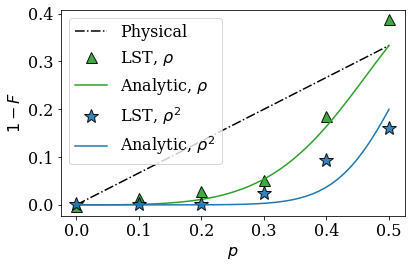

In [35]:
plt.plot(pvalues, 2 * pvalues / 3, "-.", c="k", label="Physical")

if use_rho:
    plt.plot(pvalues, 1.0 - np.real_if_close(lst_fidelities), "^", c="tab:green", mec="black", alpha=0.90, markersize=11, label=r"LST, $\rho$")
    plt.plot(pvals, 1 - analytic_fidelity(pvals), c="tab:green", label=r"Analytic, $\rho$")

if use_rho_squared:
    plt.plot(pvalues, 1.0 - np.real_if_close(lst_vd_fidelities), "*", c="tab:blue", mec="black", alpha=0.90, markersize=14, label=r"LST, $\rho^2$")
    plt.plot(pvals, 1.0 - np.real_if_close(true_rho_squared_fidelities), c="tab:blue", label=r"Analytic, $\rho^2$")

# Plot options.
# plt.ylim((-0.1, 0.35))
plt.xlabel("$p$")
plt.ylabel("$1 - F$")
plt.legend(ncol=1);
plt.tight_layout()

# plt.savefig("lst_513_threshold_rho_and_rho_squared_final_black_edges.pdf")